In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


### Manual SVD Computation:

In [5]:
url = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/ratings.csv'
url2 = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/movies.csv'
df = pd.read_csv(url)
df_name = pd.read_csv(url2)

To select only relevant columns

In [6]:
df_fix = df[['userId', 'movieId', 'rating']]
df_fix = df_fix.merge(df_name, on='movieId', how='left')
df_fix.head(3)

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller


Before we compute the SVD, we will center the rating values with each user's mean rating to eliminate user-bias:

In [7]:
user_mean = df_fix.groupby('userId')['rating'].mean()
df_fix['norm_rating'] = df_fix['rating'] - df_fix['userId'].map(user_mean)

Visually inspect the before and after normalization:

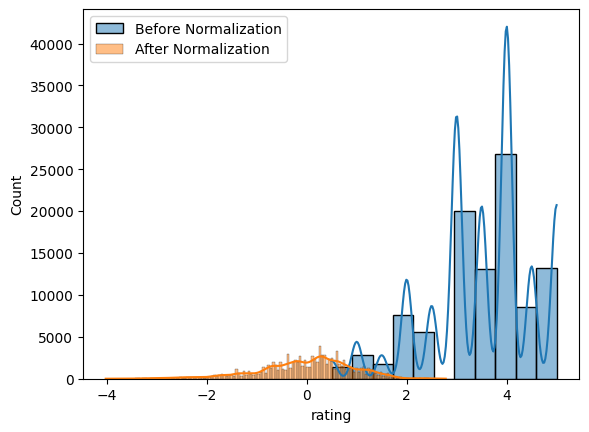

In [8]:
sns.histplot(df_fix['rating'], bins = 11, label = 'Before Normalization', kde = True)
sns.histplot(df_fix['norm_rating'], label = 'After Normalization', kde = True)
plt.legend()
plt.show()

We will make a new matrix with only numeric values from df_fix and convert the prediction results back to strings later:

In [9]:
#convert df_fix to a matrix:
df_mx = df_fix[['userId', 'movieId', 'norm_rating']].copy()
df_mx = df_mx.pivot_table(index='userId', columns='movieId', values='norm_rating', fill_value=0)
df_mx.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_fix.head(3)

,userId,movieId,rating,title,genres,norm_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,-0.366379
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,-0.366379
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,-0.366379


To calculate the sparsity of the matrix and apply csr_matrix, which can saves memory by compressing all non-zero values together.

In [11]:
#Original matrix sparsity:
total_elements = df_mx.size
non_zero_elements = np.count_nonzero(df_mx)
sparsity = 1 - (non_zero_elements / total_elements)
print(f"Original matrix sparsity: {sparsity * 100:.2f}%")

Original matrix sparsity: 98.30%


Since 98.3% of the values are zeros in the matrix, we should definitely compress them to save memory.

In [12]:
#To map the userID and movieID index to match with the csr matrix:
'''
This is necessary for creating the sparse matrix correctly since the csr_matrix can move the indices.
Here we will map the userId and movieId to indices that match the csr_matrix format.
'''
userID_idx = {uid: idx for idx, uid in enumerate(df_mx.index)}
movieID_idx = {mid: idx for idx, mid in enumerate(df_mx.columns)}

df_fix['user_idx'] = df_fix['userId'].map(userID_idx)
df_fix['movie_idx'] = df_fix['movieId'].map(movieID_idx)

#check the mapping:
df_fix.head(3)


,userId,movieId,rating,title,genres,norm_rating,user_idx,movie_idx
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,-0.366379,0,0
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,-0.366379,0,2
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,-0.366379,0,5


We will compare how much storage reduction is done by the csr compression when compared to the original matrix:

In [13]:
#Apply csr matrix:
csr_mx_norm = csr_matrix((df_fix['norm_rating'], (df_fix['user_idx'], df_fix['movie_idx'])))
csr_mx = csr_matrix((df_fix['rating'], (df_fix['user_idx'], df_fix['movie_idx'])))

#Check the storage reduction of the csr matrix:
print(f"Original matrix storage: {df_mx.size * 8} bytes")
print(f"Sparse matrix storage: {csr_mx_norm.data.size * 8 + csr_mx_norm.indices.size * 4} bytes")
storage_reduction = (1 - (csr_mx_norm.data.size + csr_mx_norm.indices.size) / df_mx.size) * 100
print(f"Storage reduction: {storage_reduction:.1f}%")


Original matrix storage: 47453120 bytes
Sparse matrix storage: 1210032 bytes
Storage reduction: 96.6%


Here we will perform a latent factor search to determine the most optimal factorization, aiming to reduce the computation complexity while minimizing RMSE.

    Single Value Decomposition(SVD) will break down a matrix into three vectors: U, S, and Vt
    1) U is the left singular matrix representing users
    2) S (sigma) is a diagonal matrix containing singular values in decreasing order. These values capture the importance of each latent feature.
    3) Vt is the right singular matrix representing the items
    4) By selecting k latent factor, we apply the truncated SVD, which reduces the original matrix complexity by retaining only the most important latent features.
    5) By performing a dot product of these three matrices, we can reconstruct an approximation of the original matrix, balancing accuracy and computional efficiency.

In [14]:
#Define the rows and cols from the original dataframe that will be used to compare with the predicted values:
tru_row = df_fix['user_idx'].values #This extracts  all userIDs
tru_col = df_fix['movie_idx'].values #This extracts all appIDs
#Ratings
tru_val_norm = df_fix['norm_rating'].values #This extracts the normalized ratings
tru_val = df_fix['rating'].values #This extracts the raw ratings

#Define parameters for the k and collect RMSE:
k_norm_values=[]
rmse_norm_values=[]

#Define parameters for the k and collect RMSE:
k_raw_values=[]
rmse_raw_values=[]

#Looping through k value to the maximum number of columns in the csr matrix:
for k in range(1, min(csr_mx_norm.shape), 10):
  u, s, vt = svds(csr_mx_norm, k=k)

  #To reverse the array orders:
  u = u[:, ::-1]
  s = np.diag(s[::-1])
  vt = vt[::-1, :]

  #To re-combine all three factorized matrices back:
  csr_mx_reconstructed = np.dot(np.dot(u, s), vt)

  #To get the predicted values:
  pred_scores = csr_mx_reconstructed[tru_row, tru_col]
  #Calculate the RMSE
  rmse = np.sqrt(mean_squared_error(tru_val_norm, pred_scores))

  #Save the results:
  k_norm_values.append(k)
  rmse_norm_values.append(rmse)
  
#Looping through the k values for the original ratings:
for k in range(1, min(csr_mx.shape), 10):
  u, s, vt = svds(csr_mx, k=k)

  #To reverse the array orders:
  u = u[:, ::-1]
  s = np.diag(s[::-1])
  vt = vt[::-1, :]

  #To re-combine all three factorized matrices back:
  csr_mx_reconstructed = np.dot(np.dot(u, s), vt)

  #To get the predicted values:
  pred_scores = csr_mx_reconstructed[tru_row, tru_col]
  #Calculate the RMSE
  rmse = np.sqrt(mean_squared_error(tru_val, pred_scores))

  #Save the results:
  k_raw_values.append(k)
  rmse_raw_values.append(rmse)
 

To visualize the change of k latent factor:

1) The RMSE vs k plot shown below captures an expected result, where RMSE decreases exponentially as k increases.

    One major reasons for such observation is because the entire dataset is used for the model training and no test or cross-validation set is available to assess the model performance.
    Therefore, as the k value increases the model becomes increasingly overfitted as shown by the exponential decrease in RMSE, reconstructing the original dataframe.

2) If we were to select the most optimal k value in this scenario, we would have to estimate a k values where increases it will only have lesser degree of change in RMSE.
    In this case, k at 200 is a good estimation. Using the SVD method, the matrix complexity is reduced by roughly 2/3 (200/600 values).

3) Notice how both normalized rating the raw ratings both showed same trend. However, the RMSE scales in the normalized ratings is much lower than the raw rating but the optimal k value is roughly the same.
    In general, a normalized rating scale reduces user/item bias and thus produces a much better model perform but it sacrifices the ability to make interpretable predictions on the rating.
    

    

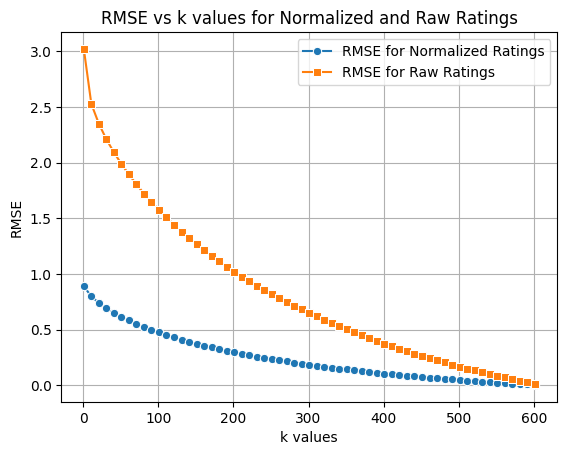

In [15]:
#Create subplots layouts:
sns.lineplot(x=k_norm_values, y=rmse_norm_values, label='RMSE for Normalized Ratings', marker='o')
sns.lineplot(x=k_raw_values, y=rmse_raw_values, label='RMSE for Raw Ratings', marker='s')
plt.xlabel('k values')
plt.ylabel('RMSE')
plt.title('RMSE vs k values for Normalized and Raw Ratings')
plt.legend()
plt.grid(True)

### Implementing train-test-split validation:

We will apply csr_matrix and SVD to the train dataset using the un-normalized rating since we want to use the model to predict user ratings.

In [16]:
#To create a train split data set to validate the model:
train, test = train_test_split(df_fix, test_size=0.2, random_state=41)
print(f"Train set size: {train.shape[0]}")
print(f"Test set size: {test.shape[0]}")

#To create a dense matrix for the training set:
train_row = train['user_idx'].values
train_col = train['movie_idx'].values

csr_train = csr_matrix((train['rating'], (train_row, train_col)))

#Manual tuning of k for the training set:
k_train_values = []
rmse_train_values = []

for k in range(1, 300, 5): #Computing half of the original matrix size
    u_train, s_train, vt_train = svds(csr_train, k=k)
    
    #To reverse the array orders:
    u_train = u_train[:, ::-1]
    s_train = np.diag(s_train[::-1])
    vt_train = vt_train[::-1, :]
    
    #To re-combine all three factorized matrices back:
    csr_train_reconstructed = np.dot(np.dot(u_train, s_train), vt_train)
    
    #To get the predicted values for the test set:
    pred_scores_train = csr_train_reconstructed[test['user_idx'].values, test['movie_idx'].values]
    
    #Calculate the RMSE
    rmse_train = np.sqrt(mean_squared_error(test['rating'], pred_scores_train))
    
    #Save the results:
    rmse_train_values.append(rmse_train)
    k_train_values.append(k)
    


Train set size: 80668
Test set size: 20168


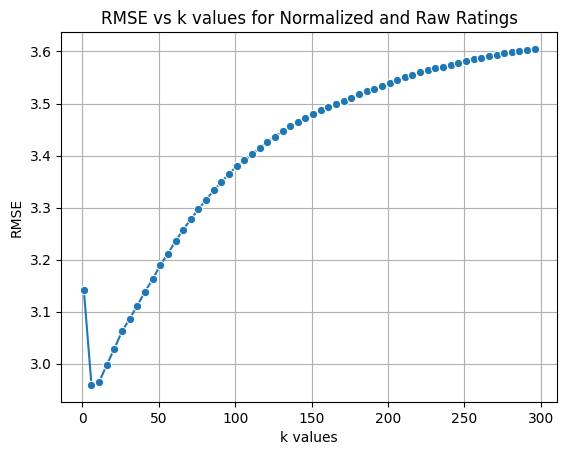

In [20]:
#To visualize the results:
sns.lineplot(x=k_train_values, y=rmse_train_values, marker='o')
plt.xlabel('k values')
plt.ylabel('RMSE')
plt.title('RMSE vs k values for Normalized and Raw Ratings')
plt.grid(True)

1) Elbow Point and Optimal k Selection

    The RMSE vs. k plot shown above reveals a clear **elbow point**, where the RMSE reaches its minimum before starting to increase again.

        The value of k at this elbow is considered the optimal number of latent factors. In this case, the optimal k is approximately 6.

2) Importance of Validation to Prevent Overfitting

    This example highlights the importance of using internal validation (such as train-test splits or cross-validation) to detect overfitting.

        As k increases beyond 6, the model begins to overfit — capturing noise rather than         generalizable patterns — leading to worsening RMSE on test data.

3) Ways to improve SVD model:
    
    SVD models can be improved further with techniques like cross-validation and regularization:

    Cross-validation:
        
        It offers a more robust alternative to a simple train-test split by repeatedly dividing the dataset into folds, training on subsets, and evaluating on holdouts. The final RMSE is averaged across all folds, providing a more reliable performance estimate.

    Regularization:
    
        In addition to cross-validation, regularization helps prevent overfitting by penalizing large latent factor values during training. These large values often arise due to user/item biases or noise. Regularization reduces their impact, leading to a more stable and generalizable model.

#### Generate rating predictions and top-N recommendations using k = 6:





In [18]:
#First we create the SVD model with the best k value:
svd_u, svd_s, svd_vt = svds(csr_train, k=6)

#To reverse the array orders:
svd_u = svd_u[:, ::-1]
svd_s = np.diag(svd_s[::-1])
svd_vt = svd_vt[::-1, :]

#To re-combine all three factorized matrices back and get the dataframe of the predicted ratings:
svd_recon = np.dot(np.dot(svd_u, svd_s), svd_vt)
svd_recon_df = pd.DataFrame(svd_recon, index=df_mx.index, columns=df_mx.columns)


**For example: we want to generate top-5 movies that userId 1 has never watched before.**

In [19]:
user_id = 1  # Example user ID to predict ratings for specific user

# Get a list of movie idx/ID that user 1 has never rated:
u1_unrated = df_mx.loc[user_id][df_mx.loc[user_id] == 0].index.tolist()

#To get the predicted ratings for user 1 for the unrated movies:
pred_ratings_u1 = svd_recon_df.loc[user_id, u1_unrated].nlargest(5)

#To geth the movie names for the predicted ratings:
u1_movie_names = df_fix[df_fix['movieId'].isin(pred_ratings_u1.index)]['title'].unique()

rec_movies = (
    df_fix[['movieId', 'title']].
    drop_duplicates()
    .set_index('movieId')
    .loc[pred_ratings_u1.index]
    ['title']
    .tolist()
)

print(f'UserId {user_id} would rate the following movies the higest:')
for movie, rating in zip(rec_movies, pred_ratings_u1.values):
    print(f' {movie}: {rating:.3f}')

UserId 1 would rate the following movies the higest:
 Aliens (1986): 2.748
 Terminator 2: Judgment Day (1991): 2.505
 Godfather, The (1972): 2.477
 Die Hard (1988): 2.453
 Sixth Sense, The (1999): 2.394


Reasons to choose SVD:

1) Excels in analyzing explicit dataset such as item/produce ratings.
2) Simple and easy to implement for small to medium dataset.
3) The decomposed matrices can be visualized.

Limitations on SVD models:
1) Requires dense matrix for computation
2) Overfitting is a concern as shown in the example above. SVD models can benefit from tuning and regularizations as explained above.
3) The interpretability of the reconstructed matrix is limited and requires carefully aligning the indices